In [ ]:
import torch
import torch.nn as nn
import timm
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from IPython.display import display
import torch.nn.functional as F
import time

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Example UNet decoder
class SimpleDecoder(nn.Module):
    def __init__(self, encoder_dim, out_channels=1):
        super().__init__()

        def up_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True), # Out Dims: [B, out_channels, H*2, W*2]
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), # Out Dims: [B, out_channels, H*2, W*2]
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )
        
        self.up1 = up_block(encoder_dim, 128)               # out dims: [B, 128, 32, 32]
        self.up2 = up_block(128, 64)                        # out dims: [B, 64, 64, 64]
        self.up3 = up_block(64, 32)                         # out dims: [B, 32, 128, 128]
        self.up4 = up_block(32, 16)                         # out dims: [B, 16, 256, 256]

        # final head: predict 2 channels -> (delta_raw, mask_logit)
        self.final_conv1 = nn.Conv2d(16, 16, 3, padding=1)
        self.final_relu = nn.ReLU(inplace=True)
        # output 2 channels (delta, mask)
        self.final_conv2 = nn.Conv2d(16, 2, 1)

        # zero-init final bias so initial delta/mask ~ 0
        nn.init.zeros_(self.final_conv2.bias)

        # learnable global scale for the delta (starts small)
        self.delta_scale = nn.Parameter(torch.tensor(0.1))

    def forward(self, x):
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        x = self.up4(x)
        x = self.final_conv1(x)
        x = self.final_relu(x)
        x = self.final_conv2(x)   # shape: [B, 2, H, W]
        return x


class ViT_UNet_NextFrame(nn.Module):
    def __init__(self, vit_model='vit_small_patch16_224', in_channels=3, out_channels=1):
        super().__init__()
        # ViT expects 3 channels, so we use a 1x1 conv to map stacked frames to 3 channels
        self.encoder = timm.create_model(vit_model, pretrained=True, features_only=True)
        encoder_dim = self.encoder.feature_info[-1]['num_chs']
        self.decoder = SimpleDecoder(encoder_dim, out_channels)
        
        
        # Freeze whole encoder
        for param in self.encoder.parameters():
            param.requires_grad = False

        # Find and unfreeze PatchEmbed robustly
        for name, module in self.encoder.named_modules():
            if module.__class__.__name__ == "PatchEmbed" or "patch_embed" in name:
                for p in module.parameters():
                    p.requires_grad = True
                print("Unfroze patch embed:", name)
                break

    
    def forward(self, x):
        feats = self.encoder(x)[-1]   # last feature map
        out = self.decoder(feats)     # [B,2,H,W]
        delta_raw = out[:, :1, ...]   # raw delta logits
        mask_logit = out[:, 1:2, ...] # mask logits

        # constrained delta + mask
        delta = torch.tanh(delta_raw) * self.decoder.delta_scale
        mask = torch.sigmoid(mask_logit)   # in [0,1]

        return delta, mask

### Load the frames

In [124]:
from PIL import Image
import os

def load_frames(frame_dir, transform=None):
    if transform is None:
        transform = transforms.ToTensor()  # converts PIL L -> tensor shape (1,H,W)
    frame_files = sorted([f for f in os.listdir(frame_dir) if f.endswith('.png')])
    frames = []
    for f in frame_files:
        img = Image.open(os.path.join(frame_dir, f)).convert('L')
        frames.append(transform(img))
    return frames

# call:
frames = load_frames("bouncing_ball_dataset")


### Dataset

In [ ]:
class FramesDataset(Dataset):
    def __init__(self, frames, num_input_frames=3, transforms=None):
        # frames: list of tensors each shape (1,H,W)
        self.frames = frames
        self.n = num_input_frames
        self.transforms = transforms

        self.samples = []
        for i in range(len(frames) - (self.n)):
            inp = torch.cat(frames[i:i+self.n], dim=0)   # (C=num_input_frames, H, W)
            last = frames[i+self.n-1]                    # (1,H,W)
            target = frames[i+self.n]                    # (1,H,W)
            self.samples.append((inp, last, target))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]
    

### Train the model

In [ ]:
class Trainer:
    def __init__(self, model, optimizer, criterion, device,
                 scheduler=None, warmup_steps=500, min_lr_fraction=0.0,
                 total_steps=None, clip_grad=None, save_path=None,
                 scheduler_step_per_batch=False,
                 early_stopping_patience=None, early_stopping_min_delta=0.0,
                 early_stopping_restore_best=True):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.warmup_steps = warmup_steps
        self.min_lr_fraction = min_lr_fraction
        self.total_steps = total_steps
        self.clip_grad = clip_grad
        self.save_path = save_path
        self.scheduler_step_per_batch = scheduler_step_per_batch

        self.early_stopping_patience = early_stopping_patience
        self.early_stopping_min_delta = early_stopping_min_delta
        self.early_stopping_restore_best = early_stopping_restore_best

        self.global_step = 0
        self.scheduler = scheduler

    def _save_checkpoint(self, tag="last", is_best=False):
        if not self.save_path:
            return
        state = {
            "model_state": self.model.state_dict(),
            "optim_state": self.optimizer.state_dict(),
            "scheduler_state": self.scheduler.state_dict() if self.scheduler is not None else None,
            "global_step": self.global_step,
        }
        torch.save(state, f"{self.save_path}_{tag}.pt")
        if is_best:
            torch.save(state, f"{self.save_path}_best.pt")

    def load(self, path, map_location=None):
        ckpt = torch.load(path, map_location=map_location)
        self.model.load_state_dict(ckpt["model_state"])
        self.optimizer.load_state_dict(ckpt["optim_state"])
        if self.scheduler is not None and ckpt.get("scheduler_state") is not None:
            try:
                self.scheduler.load_state_dict(ckpt["scheduler_state"])
            except Exception:
                pass
        self.global_step = ckpt.get("global_step", 0)

    def _current_lrs(self):
        return [group['lr'] for group in self.optimizer.param_groups]

    def _train_one_epoch(self, train_loader, epoch, log_every=50):
        self.model.train()
        running_loss = 0.0
        start = time.time()
        for i, (inputs, lasts, targets) in enumerate(train_loader):
            inputs = inputs.to(self.device)
            lasts = lasts.to(self.device)
            targets = targets.to(self.device)

            self.optimizer.zero_grad()
            delta, mask = self.model(inputs)
            pred = lasts * (1.0 - mask) + (lasts + delta) * mask
            loss = self.criterion(pred, targets)
            loss = loss + 0.01 * mask.mean()

            loss.backward()
            if self.clip_grad is not None:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_grad)
            self.optimizer.step()

            if self.scheduler is not None and self.scheduler_step_per_batch:
                try:
                    self.scheduler.step()
                except Exception:
                    pass

            self.global_step += 1
            running_loss += loss.item()

            if (i + 1) % log_every == 0:
                avg = running_loss / float(i + 1)
                lrs = self._current_lrs()
                if len(lrs) == 1:
                    lr_info = f"lr={lrs[0]:.3e}"
                else:
                    lr_info = "lrs=" + ",".join(f"{x:.3e}" for x in lrs)
                print(f"Epoch {epoch} Step {i+1}/{len(train_loader)}  loss={avg:.6f}  {lr_info}")

        elapsed = time.time() - start
        epoch_loss = running_loss / max(1, len(train_loader))
        lrs = self._current_lrs()
        if len(lrs) == 1:
            lr_info = f"lr={lrs[0]:.3e}"
        else:
            lr_info = "lrs=" + ",".join(f"{x:.3e}" for x in lrs)
        print(f"Epoch {epoch} completed in {elapsed:.1f}s  avg_loss={epoch_loss:.6f}  {lr_info}")
        return epoch_loss

    @torch.no_grad()
    def validate(self, val_loader):
        self.model.eval()
        tot = 0.0
        count = 0
        for inputs, lasts, targets in val_loader:
            inputs = inputs.to(self.device)
            lasts = lasts.to(self.device)
            targets = targets.to(self.device)
            delta, mask = self.model(inputs)
            pred = lasts * (1.0 - mask) + (lasts + delta) * mask
            loss = self.criterion(pred, targets)
            tot += loss.item()
            count += 1
        return tot / max(1, count)

    def fit(self, train_loader, epochs=10, val_loader=None, log_every=50, save_every=1):
        history = {"train_loss": [], "val_loss": []}
        best_val = float('inf')
        best_ckpt = None
        no_improve = 0
        best_epoch = None

        for epoch in range(1, epochs + 1):
            train_loss = self._train_one_epoch(train_loader, epoch, log_every=log_every)
            history["train_loss"].append(train_loss)

            if self.scheduler is not None and not self.scheduler_step_per_batch:
                try:
                    self.scheduler.step()
                except Exception:
                    pass

            if val_loader is not None:
                val_loss = self.validate(val_loader)
                history["val_loss"].append(val_loss)
                print(f"Validation loss: {val_loss:.6f}")

                improved = (val_loss + self.early_stopping_min_delta) < best_val
                if improved:
                    best_val = val_loss
                    no_improve = 0
                    best_epoch = epoch
                    # save best checkpoint
                    if self.save_path:
                        self._save_checkpoint(tag=f"epoch{epoch}", is_best=True)
                    # keep best state in memory to optionally restore without file IO
                    best_ckpt = {
                        "model_state": self.model.state_dict(),
                        "optim_state": self.optimizer.state_dict(),
                        "scheduler_state": self.scheduler.state_dict() if self.scheduler is not None else None,
                        "global_step": self.global_step,
                    }
                else:
                    no_improve += 1

                if self.early_stopping_patience is not None and no_improve >= self.early_stopping_patience:
                    print(f"Early stopping triggered (no improvement for {no_improve} epochs).")
                    break

            if self.save_path and (epoch % save_every == 0 or epoch == epochs):
                self._save_checkpoint(tag=f"epoch{epoch}")

        if self.save_path:
            self._save_checkpoint(tag="final")

        if self.early_stopping_restore_best and best_ckpt is not None:
            try:
                self.model.load_state_dict(best_ckpt["model_state"])
                self.optimizer.load_state_dict(best_ckpt["optim_state"])
                if self.scheduler is not None and best_ckpt.get("scheduler_state") is not None:
                    try:
                        self.scheduler.load_state_dict(best_ckpt["scheduler_state"])
                    except Exception:
                        pass
                print(f"Restored best model from epoch {best_epoch} with val_loss={best_val:.6f}")
            except Exception:
                pass

        return history

In [ ]:
# Model, loss, optimizer
model = ViT_UNet_NextFrame(vit_model='vit_small_patch16_224', in_channels=3, out_channels=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

# # Load dataset and dataloader
# dataset = FramesDataset(frames, num_input_frames=3)
# loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)  # adjust batch_size

In [ ]:
# get sorted png paths (no image loaded yet)
paths = list_frame_paths("bouncing_ball_dataset")

# create lazy dataset (FramesDataset uses Image.open in __getitem__)
dataset = FramesDataset(paths, num_input_frames=3)

# deterministic train/val split
n = len(dataset)
val_len = int(0.1 * n)
train_len = n - val_len
generator = torch.Generator().manual_seed(42)
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_len, val_len], generator=generator)

# DataLoader: start with small batch and increase until OOM risk
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,
                          num_workers=4, pin_memory=True,
                          persistent_workers=True, prefetch_factor=2)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False,
                          num_workers=2, pin_memory=True,
                          persistent_workers=True, prefetch_factor=2)

In [ ]:
# split dataset into train/val
from torch.utils.data import random_split

val_frac = 0.1
n = len(dataset)
val_len = int(n * val_frac)
train_len = n - val_len
train_ds, val_ds = random_split(dataset, [train_len, val_len])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=0)

# instantiate trainer (you already have Trainer that accepts val_loader)
trainer = Trainer(model, optimizer, criterion, device,
                  scheduler=scheduler, scheduler_step_per_batch=True,
                  clip_grad=1.0)

history = trainer.fit(train_loader=train_loader, epochs=epochs, val_loader=val_loader, log_every=20)

# inspect / plot validation loss
print(history['val_loss'])
import matplotlib.pyplot as plt
plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.show()

In [134]:
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR

epochs = 20
warmup_steps = 100
total_steps = epochs * len(loader)
min_lr = 0.0

warmup_scheduler = LinearLR(optimizer, start_factor=1e-6, total_iters=warmup_steps)
cosine_scheduler = CosineAnnealingLR(optimizer, T_max=max(1, total_steps - warmup_steps), eta_min=min_lr)
scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, cosine_scheduler], milestones=[warmup_steps])

trainer = Trainer(model, optimizer, criterion, device,
                  scheduler=scheduler, scheduler_step_per_batch=True,
                  clip_grad=1.0)


history = trainer.fit(train_loader=loader, epochs=epochs)

Epoch 1 Step 20/32  loss=0.018014  lr=4.000e-05
Epoch 1 completed in 28.6s  avg_loss=0.017747  lr=6.400e-05
Epoch 2 Step 20/32  loss=0.016875  lr=1.040e-04
Epoch 2 completed in 28.8s  avg_loss=0.016727  lr=1.280e-04
Epoch 3 Step 20/32  loss=0.016121  lr=1.680e-04
Epoch 3 completed in 28.9s  avg_loss=0.015938  lr=1.920e-04
Epoch 4 Step 20/32  loss=0.015016  lr=2.320e-04
Epoch 4 completed in 30.7s  avg_loss=0.014704  lr=2.560e-04
Epoch 5 Step 20/32  loss=0.013488  lr=2.960e-04
Epoch 5 completed in 53.7s  avg_loss=0.013228  lr=3.200e-04
Epoch 6 Step 20/32  loss=0.011922  lr=3.600e-04
Epoch 6 completed in 34.3s  avg_loss=0.011693  lr=3.840e-04
Epoch 7 Step 20/32  loss=0.010769  lr=4.240e-04
Epoch 7 completed in 44.3s  avg_loss=0.010657  lr=4.480e-04
Epoch 8 Step 20/32  loss=0.010092  lr=4.880e-04
Epoch 8 completed in 43.6s  avg_loss=0.009975  lr=5.120e-04
Epoch 9 Step 20/32  loss=0.009647  lr=5.520e-04
Epoch 9 completed in 44.7s  avg_loss=0.009529  lr=5.760e-04
Epoch 10 Step 20/32  loss=0.

KeyboardInterrupt: 

MSE: 0.006736


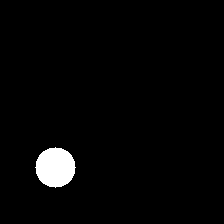

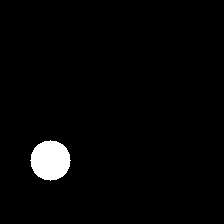

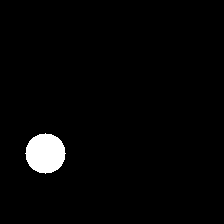

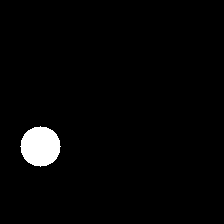

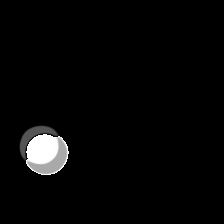

In [138]:
import torchvision.transforms.functional as TF


# pick sample index
idx = 1
inp, last, target = dataset[idx]        # inp: (C=num_input_frames,H,W), last/target: (1,H,W)

# add batch dim and send to device
inp = inp.unsqueeze(0).to(device)       # (1,C,H,W)
last = last.unsqueeze(0).to(device)     # (1,1,H,W)
target = target.unsqueeze(0).to(device) # (1,1,H,W)

model.eval()
with torch.no_grad():
    delta, mask = model(inp)             # predicted delta (1,1,H,W)
    pred = last * (1.0 - mask) + (last + delta) * mask            # predicted next frame (1,1,H,W)



# compute MSE
loss = criterion(pred, target)
print(f'MSE: {loss.item():.6f}')

# display
pred_img = pred.squeeze(0).squeeze(0).cpu()   # (H,W)
target_img = target.squeeze(0).squeeze(0).cpu()
for frame in inp.squeeze(0):
    display(TF.to_pil_image(frame.cpu()))

display(TF.to_pil_image(target_img))
display(TF.to_pil_image(pred_img))

### Predict next based on the prediction